# Neural network

This notebook showcases the use of a neural network, implemented in the neuralnet.py module. We test our implementation on the MNIST dataset and on two simple artificial datasets.

Our implementation supports:
- Multicategory classification
- Dropout regularisation
- Cross entropy or mean squared error loss function

To find suitable hyperparameters, we use k-fold cross validation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import load_digits

In [2]:
from neuralnet import NNLearner

## Testing on MNIST

### Loading the dataset

We begin by loading the MNIST dataset. For multiclass problems, our neural network implementation requires that the target is one-hot encoded. Then we split into a training and testing set.

<Figure size 640x480 with 0 Axes>

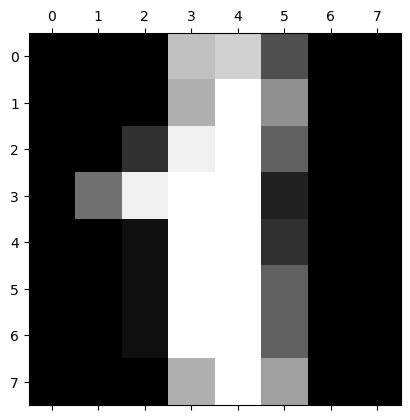

In [3]:
digits = load_digits(as_frame = True)
X = digits.data
Y = pd.get_dummies(digits.target) # One hot encoding

plt.gray()
plt.matshow(digits.images[1])
plt.show()

We split into a training and a test set. We will perform k-fold cross validation on the training set, and hold out on evaluating performance on the test set until hyperparameters have been chosen.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

### K-fold cross validation

To find suitable hyperparameters, we perform k-fold cross validation. By experimentation we found the following hyperparameters which give good performance:

In [5]:
lr = 0.5
epochs = 200
geom = [100]
drop = 0.5

In [6]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracy = np.array([])
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f"Learning fold {i+1}...")
    X_kf_train = X_train.loc[X_train.index[train_index]]
    X_kf_test  = X_train.loc[X_train.index[test_index]]
    Y_kf_train = Y_train.loc[X_train.index[train_index]]
    Y_kf_test  = Y_train.loc[X_train.index[test_index]]
    learner = NNLearner(X_kf_train,Y_kf_train,
                        learningRate = lr,
                        numIterations = epochs,
                        geometry = geom,
                        dropoutRate = drop)
    learner.learn()
    acc = (learner.predictCat(X_kf_test) == Y_kf_test.idxmax(axis=1)).mean()
    accuracy = np.append(accuracy,acc)

print(f'Mean accuracy of {100*accuracy.mean():0.2f}% with variance {accuracy.var():.5f}.')

Learning fold 1...


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 825.67it/s]


Learning fold 2...


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 847.75it/s]


Learning fold 3...


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 857.50it/s]


Learning fold 4...


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 886.31it/s]


Learning fold 5...


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 814.40it/s]

Mean accuracy of 96.38% with variance 0.00004.


This looks like a satisfactory choice of hyperparameters. To improve the validation accuracy, we would conduct a hyperparameter grid search (or use a different neural net architecture, such as convolutional neural nets).

### Evaluating on the test set

Having chosen the hyperparameters above, we train the model on the entire training set and finally evaluate on the test set, which is as of yet unseen by the model.

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 701.59it/s]


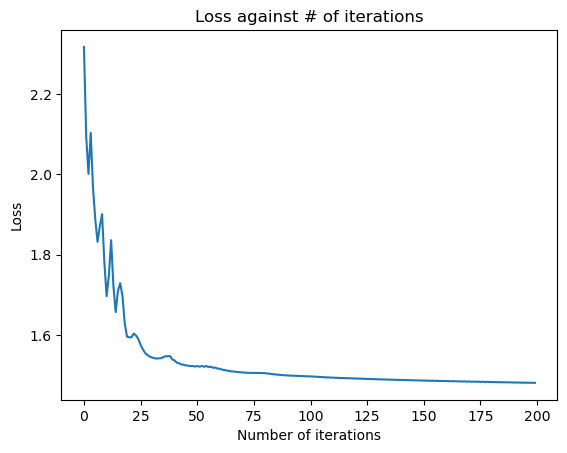

In [7]:
learner = NNLearner(X_train,Y_train,
                    learningRate = 0.5,
                    numIterations = 200,
                    geometry = [100],
                    dropoutRate = 0.5)
learner.learn()
learner.plotLosses()

Now we can compute the model accuracy on the testing set!

In [8]:
print(f'Training accuracy: {learner.trainingAccuracy*100:.2f}%.')
test_accuracy = (learner.predictCat(X_test) == Y_test.idxmax(axis=1)).mean()
print(f'Test set accuracy: {test_accuracy*100:.2f}%.')

Training accuracy: 98.47%.
Test set accuracy: 96.94%.


The categories as predicted on the test can be obtained like so:

In [9]:
learner.predictCat(X_test)

525     9
936     9
737     3
619     3
1789    8
       ..
64      4
230     5
153     3
57      2
1574    9
Length: 360, dtype: int64

## Artifical dataset 1: a simple multicategory problem

### Creating the dataset and plotting

In [10]:
x = [np.random.uniform(-1.5,1.5) for i in range(100)]
y = map(lambda x : 'A' if x < -0.5 else ('B' if x < 0.5 else 'C'), x)
X = pd.DataFrame(x)
Y = pd.get_dummies(y)

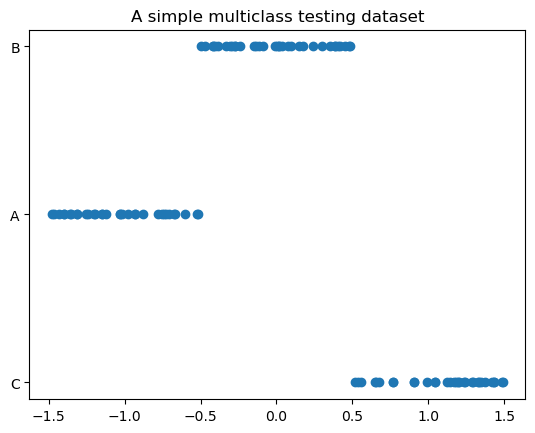

In [11]:
plt.scatter(X, Y.idxmax(axis=1))
plt.title('A simple multiclass testing dataset')
plt.show()

### Training the model

Here we use a simple logistic regression (i.e. a neural network with 0 hidden layers). The input to the learner is the dataframe, the name of the dependent column (in this case 'y'), as well as the desired learning rate, number of iterations and network geometry.

In [12]:
learner = NNLearner(X,Y, learningRate = 0.3, numIterations = 2000)

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 8107.34it/s]


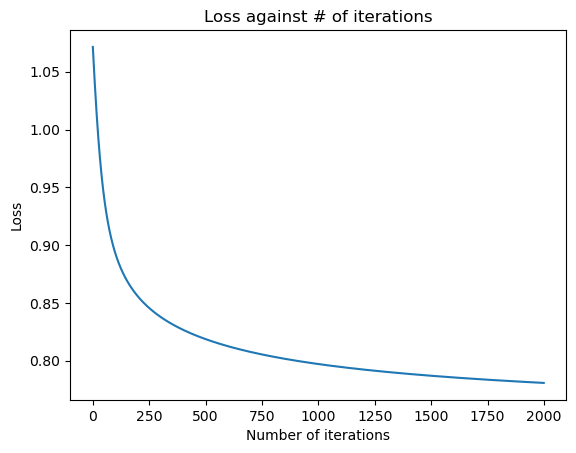

Training accuracy: 95%.


In [13]:
learner.learn()
learner.plotLosses()
print(f'Training accuracy: {learner.trainingAccuracy*100:.0f}%.')

## Artifical dataset 2: a circular dataset

### Creating the dataset and plotting

We create the dataset by using polar coordinates and the following helper function:

In [14]:
def random2Dpoint(scale):
    """
    Returns a random point in an annulus of radius ~scale.
    """
    theta = np.random.uniform(0,2*np.pi)
    r = np.random.rand() + scale
    return r*np.cos(theta),r*np.sin(theta)

In [15]:
numP = 100
points = [(*random2Dpoint(0),0.) for i in range(numP)] + [(*random2Dpoint(1),1.) for i in range(numP)]
df = pd.DataFrame(points)
df.columns = ['x1','x2','y']
X = df[['x1','x2']]
Y = df['y']

We plot the dataset to reveal its simple structure. Points are colored according to their y-value.

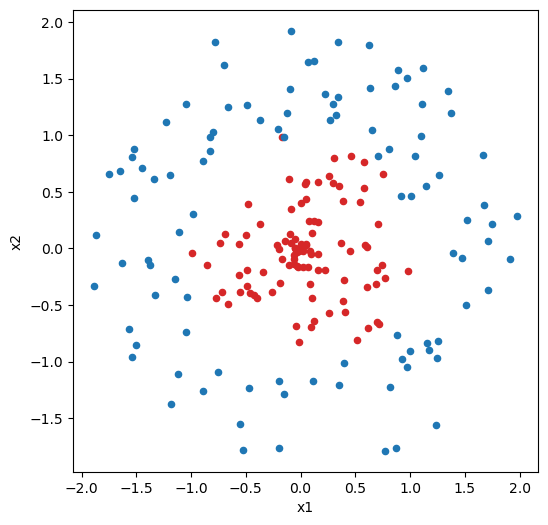

In [16]:
colors = {0. : 'tab:red', 1. : 'tab:blue'}
fig, ax = plt.subplots(figsize=(6, 6))

grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, x='x1', y='x2', kind='scatter', color=colors[key])
plt.show()

### Training the model

Here we use a neural network with 10 hidden layers - logistic regression (with an affine linear activation) cannot fit the required circular decision boundary. For illustration, we use a mean squared error loss function here.

In [17]:
learner = NNLearner(X,Y,
                    learningRate = 0.5,
                    numIterations = 400,
                    geometry = [10],
                    lossFn = 'MSE')

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 5273.00it/s]


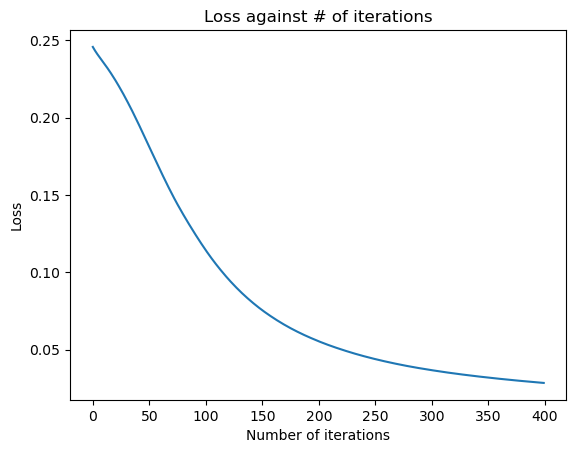

Training accuracy: 98%.


In [18]:
learner.learn()
learner.plotLosses()
print(f'Training accuracy: {learner.trainingAccuracy*100:.0f}%.')